# Sampling from an arbitrary hazard function

This notebook shows how we can start with any arbitrary hazard function, and sample failure times (both censored and uncensored). We show that the presence of censoring causes histograms and ECDFs to be systematically biased if we only work with the uncensored data points. 

To sample from the hazard function, we do the following: 
1. Integrate the hazard to get cumulative hazard, H(t)
2. Use standard transfrom from cumulative hazard to survival function, S(t)
3. Use 1-S(t) to get the CDF 
4. Use inversion to get inverse CDF, and then draw random samples from the CDF. 

Reference: https://gist.github.com/jcrudy/10481743


In [1]:
import sys
print(sys.executable)

C:\Nayef\survival-analysis-notes\.venv\Scripts\python.exe


In [2]:
import numpy as np
import scipy.integrate
from matplotlib import pyplot as plt
from statsmodels.distributions import ECDF

In [3]:
class HazardSampler:
    def __init__(self, hazard, start=0.0, step=None):
        self.hazard = hazard
        if step is None:
            # heuristic for setting step size to be used in numerical inverse CDF
            # implementation
            # todo: are there better heuristics?
            h0 = hazard(0.0)
            if h0 > 0:
                step = 2.0 / hazard(0.0)
            else:
                # Reasonable default. Not efficient in some cases.
                step = 200.0 / scipy.integrate.quad(hazard, 0.0, 100.0)
        self.cumulative_hazard = CumulativeHazard(hazard)
        self.survival_function = SurvivalFunction(self.cumulative_hazard)
        self.cdf = Cdf(self.survival_function)
        self.inverse_cdf = InverseCdf(self.cdf, start=start, step=step, lower=0.0)
        self.sampler = InversionTransformSampler(self.inverse_cdf)
    def draw(self):
        return self.sampler.draw()

In [4]:
class InversionTransformSampler:
    def __init__(self, inverse_cdf):
        self.inverse_cdf = inverse_cdf
    def draw(self):
        u = np.random.uniform(0, 1)
        return self.inverse_cdf(u)

In [5]:
class CumulativeHazard:
    def __init__(self, hazard):
        self.hazard = hazard
    def __call__(self, t):
        return scipy.integrate.quad(self.hazard, 0.0, t)[0]

In [6]:
class SurvivalFunction:
    def __init__(self, cumulative_hazard):
        self.cumulative_hazard = cumulative_hazard
    def __call__(self, t):
        return np.exp(-self.cumulative_hazard(t))

In [7]:
class Cdf:
    def __init__(self, survival_function):
        self.survival_function = survival_function
    def __call__(self, t):
        return 1.0 - self.survival_function(t)

In [8]:
class InverseCdf:
    def __init__(
        self, cdf, start, step, precision=1e-8, lower=float("-inf"), upper=float("inf")
    ):
        self.cdf = cdf
        self.precision = precision
        self.start = start
        self.step = step
        self.lower = lower
        self.upper = upper
    def __call__(self, target_p):
        """
        Takes a proportion p (y-axis value of the cdf) and returns the corresponding
        x value from the cdf (to within a certain precision level).
        """
        last_diff = None
        step = self.step
        current_x = self.start
        while True:
            current_cdf_value = self.cdf(current_x)
            diff = current_cdf_value - target_p
            if abs(diff) < self.precision:
                break
            elif diff < 0:
                # current_x is too far to the left, so we increase it
                current_x = min(current_x + step, self.upper)
                if last_diff is not None and last_diff > 0:
                    # if diff and last_diff are opposite signs, take smaller
                    # optimization steps
                    step *= 0.5
                last_diff = diff
            else:
                # current_x is too far to the right, so we decrease it
                current_x = max(current_x - step, self.lower)
                if last_diff is not None and last_diff < 0:
                    # if diff and last_diff are opposite signs, take smaller
                    # optimization steps
                    step *= 0.5
                last_diff = diff
        return current_x

C:\Nayef\survival-analysis-notes\.venv\lib\site-packages\ipykernel_launcher.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Nayef\survival-analysis-notes\.venv\lib\site-packages\ipykernel_launcher.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


done


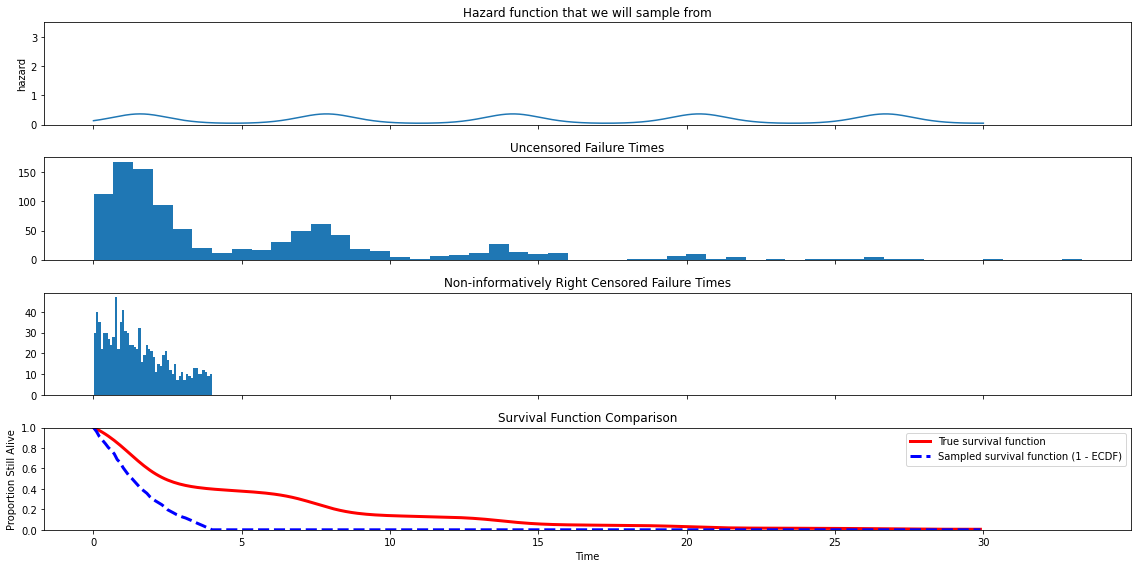

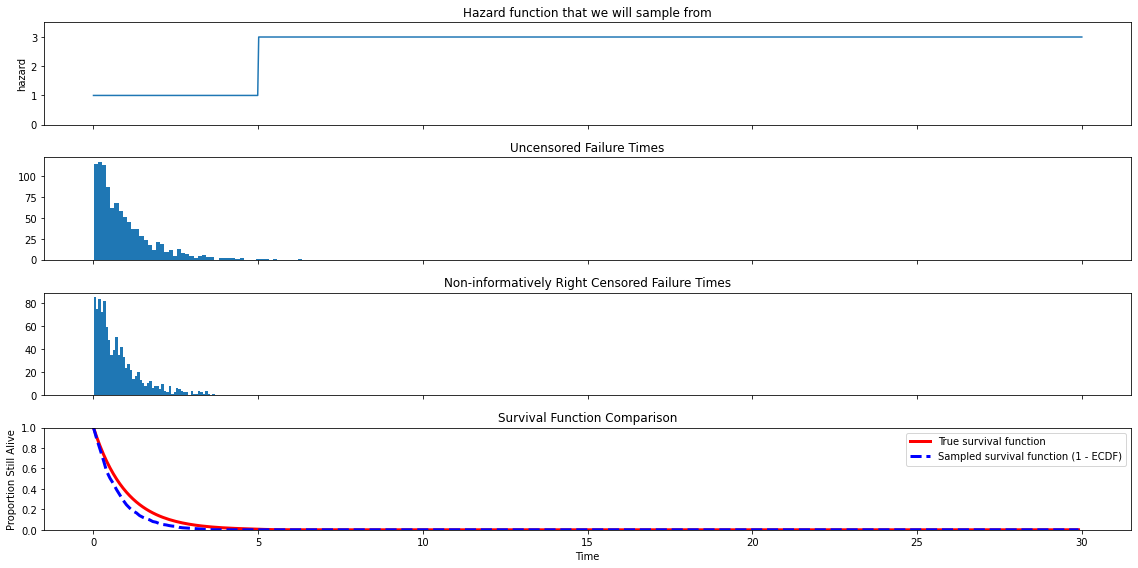

In [9]:
# Set a random seed and sample size
np.random.seed(1)
m = 1000

# Define hazard functions to sample from
def hazard_sine(t):
    return np.exp(np.sin(t) - 2.0)

def hazard_piecewise(t):
    return np.where(t < 5, 1, 3)

# todo: add weibull hazard fn

hazard_functions = [hazard_sine, hazard_piecewise]

for hazard in hazard_functions:
    fig, ax = plt.subplots(4, 1, sharex=True, figsize=(16, 8))
    xmax = 30

    txt = "Hazard function that we will sample from"
    x = np.linspace(0, xmax, 1000)
    y = hazard(x)
    ax[0].plot(x, y)
    ax[0].set_ylabel("hazard")
    ax[0].set_title(txt)
    ax[0].set_ylim(0, 3.5)

    # Sample failure times from the hazard function
    sampler = HazardSampler(hazard)
    failure_times = np.array([sampler.draw() for _ in range(m)])

    # Apply some non-informative right censoring, just to demonstrate how it's done
    censor_times = np.random.uniform(0.0, 4, size=m)
    y = np.minimum(failure_times, censor_times)
    c = 1.0 * (censor_times > failure_times)

    # Make some plots of the simulated data
    # Plot a histogram of failure times from this hazard function
    ax[1].hist(failure_times, bins=50)
    ax[1].set_title("Uncensored Failure Times")

    # Plot a histogram of censored failure times from this hazard function
    ax[2].hist(y, bins=50)
    ax[2].set_title("Non-informatively Right Censored Failure Times")

    # Plot the empirical survival function (based on the censored sample) against
    # the actual survival function
    t = np.arange(0, xmax, 0.1)
    S = np.array([sampler.survival_function(t[i]) for i in range(len(t))])
    S_hat = 1.0 - ECDF(y)(t)

    ax[3].set_title("Survival Function Comparison")
    ax[3].plot(t, S, "r", lw=3, label="True survival function")
    ax[3].plot(t, S_hat, "b--", lw=3, label="Sampled survival function (1 - ECDF)")
    ax[3].legend()
    ax[3].set_xlabel("Time")
    ax[3].set_ylabel("Proportion Still Alive")
    ax[3].set_ylim(0, 1)
    plt.tight_layout()
    fig.show()

print("done")
